In [1]:
import pandas as pd 
import numpy as np 


In [132]:
df2 = pd.read_csv('Mumbai House Prices.csv')

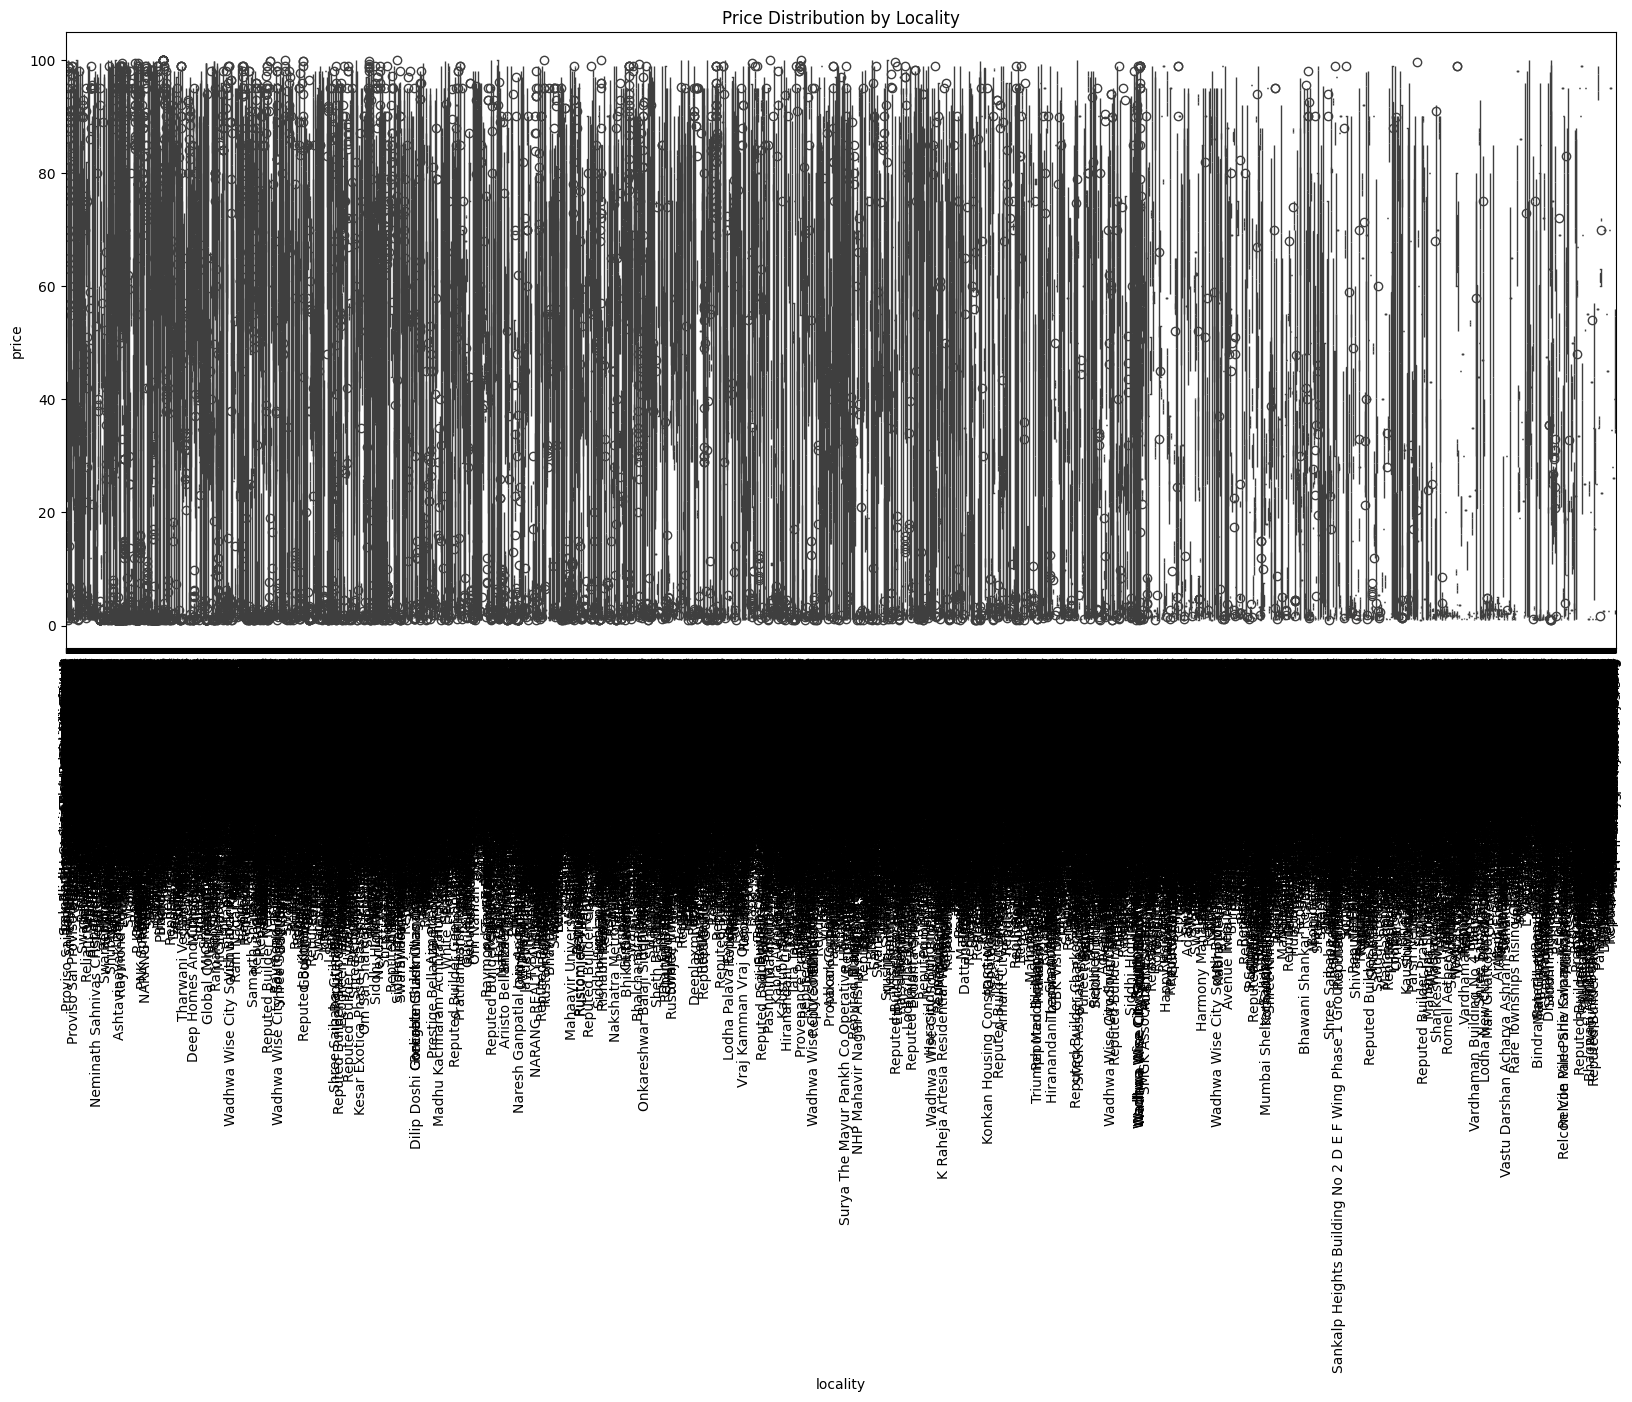

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,8))
sns.boxplot(x=df2['locality'], y=df2['price'])
plt.xticks(rotation=90)
plt.title("Price Distribution by Locality")
plt.show()


In [16]:
df = pd.read_csv('Mumbai House Prices.csv')

In [17]:
df.size

684342

In [18]:
df.shape

(76038, 9)

In [19]:
df.describe

<bound method NDFrame.describe of        bhk       type                              locality  area  price  \
0        3  Apartment   Lak And Hanware The Residency Tower   685   2.50   
1        2  Apartment     Radheya Sai Enclave Building No 2   640  52.51   
2        2  Apartment                         Romell Serene   610   1.73   
3        2  Apartment  Soundlines Codename Urban Rainforest   876  59.98   
4        2  Apartment                         Origin Oriana   659  94.11   
...    ...        ...                                   ...   ...    ...   
76033    3  Apartment                     Parinee Liva Roca  1527   7.00   
76034    5  Apartment                     Parinee Liva Roca  3049  12.00   
76035    4  Apartment                         Lodha Seaview  3313  10.00   
76036    2  Apartment                        Hubtown Serene  1305   4.25   
76037    5  Apartment              Sunteck Signature Island  5200  25.00   

      price_unit                region              s

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76038 entries, 0 to 76037
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bhk         76038 non-null  int64  
 1   type        76038 non-null  object 
 2   locality    76038 non-null  object 
 3   area        76038 non-null  int64  
 4   price       76038 non-null  float64
 5   price_unit  76038 non-null  object 
 6   region      76038 non-null  object 
 7   status      76038 non-null  object 
 8   age         76038 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 5.2+ MB


In [22]:
# New cell: data cleaning & imputation
def clean_df(df, name='df'):
    import numpy as np
    print(f'Cleaning {name}: shape before {df.shape}')
    missing_frac = df.isna().mean().sort_values(ascending=False)
    print('Top missing fractions:')
    print(missing_frac.head(10))

    # 1) Drop columns with very high missing rate (>50%)
    to_drop = missing_frac[missing_frac > 0.5].index.tolist()
    if to_drop:
        print('Dropping columns with >50% missing:', to_drop)
        df = df.drop(columns=to_drop)

    # 2) If a price-like target exists, drop rows missing the target
    price_cols = [c for c in df.columns if 'price' in c.lower()]
    for p in price_cols:
        before = df.shape[0]
        df = df[~df[p].isna()]
        after = df.shape[0]
        print(f'Dropped {before-after} rows with missing target column "{p}"')

    # 3) Numeric columns: impute with median
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        if df[col].isna().any():
            med = df[col].median()
            df[col].fillna(med, inplace=True)
            print(f'Imputed numeric "{col}" with median={med}')

    # 4) Categorical columns: impute with mode or 'Unknown'
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        if df[col].isna().any():
            mode = df[col].mode()
            fill = mode.iloc[0] if not mode.empty else 'Unknown'
            df[col].fillna(fill, inplace=True)
            print(f'Imputed categorical "{col}" with "{fill}"')

    print(f'Cleaning {name} complete: shape after {df.shape}')
    return df

# Apply cleaning to both datasets
df = clean_df(df, 'Mumbai House Prices')
# ...existing code...

Cleaning Mumbai House Prices: shape before (76038, 9)
Top missing fractions:
bhk           0.0
type          0.0
locality      0.0
area          0.0
price         0.0
price_unit    0.0
region        0.0
status        0.0
age           0.0
dtype: float64
Dropped 0 rows with missing target column "price"
Dropped 0 rows with missing target column "price_unit"
Cleaning Mumbai House Prices complete: shape after (76038, 9)


In [25]:
def detect_outliers(df, method='iqr', iqr_factor=1.5, z_thresh=3.0, rare_frac=0.01, sample_n=5):
    import numpy as np
    import pandas as pd
    from scipy import stats

    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    outlier_summary = []
    outlier_masks = {}

    # Numeric columns
    for col in num_cols:
        s = df[col].dropna()
        if s.empty:
            outlier_summary.append((col, 'numeric', 0, 0.0, None))
            outlier_masks[col] = pd.Series(False, index=df.index)
            continue

        if method == 'zscore':
            z = (df[col] - s.mean()) / s.std(ddof=0)
            mask = z.abs() > z_thresh
        else:  # iqr
            q1 = s.quantile(0.25)
            q3 = s.quantile(0.75)
            iqr = q3 - q1
            lower = q1 - iqr_factor * iqr
            upper = q3 + iqr_factor * iqr
            mask = (df[col] < lower) | (df[col] > upper)

        count = int(mask.sum())
        pct = float(count) / len(df) if len(df) else 0.0
        sample_vals = df.loc[mask, col].dropna().unique()[:sample_n].tolist()
        outlier_summary.append((col, 'numeric', count, pct, sample_vals))
        outlier_masks[col] = mask.fillna(False)

    # Categorical: flag rare categories
    cat_summary = []
    for col in cat_cols:
        vc = df[col].value_counts(dropna=False)
        rarities = vc[vc / len(df) < rare_frac]
        count_rare = int(rarities.sum()) if not rarities.empty else 0
        pct_rare = float(count_rare) / len(df) if len(df) else 0.0
        rare_examples = rarities.index[:sample_n].tolist()
        cat_summary.append((col, 'categorical', count_rare, pct_rare, rare_examples))

    # Combine summaries
    summary_df = pd.DataFrame(
        outlier_summary + cat_summary,
        columns=['column', 'type', 'outlier_count', 'outlier_frac', 'examples']
    ).sort_values(['type', 'outlier_frac'], ascending=[True, False]).reset_index(drop=True)

    # Row-level outlier counts (numeric only)
    if num_cols:
        masks_df = pd.concat([outlier_masks[c] for c in num_cols], axis=1)
        masks_df.columns = num_cols
        df['_numeric_outlier_count'] = masks_df.sum(axis=1).astype(int)
    else:
        df['_numeric_outlier_count'] = 0

    # Print concise report
    print("Outlier report (top columns):")
    print(summary_df.head(20).to_string(index=False))
    print("\nRows with most numeric outliers (top 10):")
    print(df.sort_values('_numeric_outlier_count', ascending=False)[['_numeric_outlier_count'] + (num_cols[:5] if len(num_cols)>5 else num_cols)].head(10).to_string())

    return summary_df, df

# Example usage (adjust method -> 'zscore' if you prefer Z-score)
outlier_summary, df = detect_outliers(df, method='iqr', iqr_factor=1.5, rare_frac=0.01)

Outlier report (top columns):
                column        type  outlier_count  outlier_frac                                                                                         examples
              locality categorical          75177      0.988677 [Sheth Avalon, T Bhimjyani The Verraton, ACME Ozone Phase 2, Runwal Gardens, JP North Barcelona]
                region categorical          17482      0.229911                                [Dahisar, Bhayandar East, Ambernath East, Goregaon East, Kamothe]
                  type categorical            302      0.003972                                                            [Villa, Independent House, Penthouse]
            price_unit categorical              0      0.000000                                                                                               []
                status categorical              0      0.000000                                                                                               []
    

In [33]:
df['price'].max()


np.float64(99.99)

In [34]:
df['bhk'].max()

np.int64(10)

In [36]:
df.loc[df['bhk'].idxmax()]

bhk                                                      10
type                                              Apartment
locality                  Reputed Builder Varsha Apartments
area                                                   6200
price                                                  33.0
price_unit                                               Cr
region                                                 Juhu
status                                        Ready to move
age                                                  Resale
_numeric_outlier_count                                    3
Name: 8454, dtype: object

In [29]:
df.loc[df['price'].idxmax()]

bhk                                                             2
type                                                    Apartment
locality                  Kalpataru Eternia At Kalpataru Parkcity
area                                                          531
price                                                       99.99
price_unit                                                      L
region                                                 Thane West
status                                         Under Construction
age                                                           New
_numeric_outlier_count                                          0
Name: 10417, dtype: object

In [37]:
df['price_unit'].unique()

array(['Cr', 'L'], dtype=object)

In [130]:
df['locality'].unique()

array(['Lak And Hanware The Residency Tower',
       'Radheya Sai Enclave Building No 2', 'Romell Serene', ...,
       'Ahuja Prasadam Phase III', 'HBS Marineview', 'Hubtown Serene'],
      shape=(9782,), dtype=object)

In [39]:
conversion = {
    'Cr': 1,
    'cr': 1,
    'CR': 1,

    'L': 0.01,
    'l': 0.01,
    'Lakh': 0.01
}


In [40]:
df['price'] = df.apply(
    lambda row: row['price'] * conversion.get(row['price_unit'], 1),
    axis=1
)

In [41]:
df.loc[df['price'].idxmax()]

bhk                                               5
type                                      Apartment
locality                  Anchor Daewoo South Ridge
area                                           7200
price                                          60.0
price_unit                                       Cr
region                               Napeansea Road
status                                Ready to move
age                                          Resale
_numeric_outlier_count                            2
Name: 38199, dtype: object

In [42]:
df = df.drop(columns=['price_unit'])

In [43]:
df['bhk'].unique()

array([ 3,  2,  5,  1,  4,  6,  9,  8, 10,  7])

In [44]:
df['bhk'].value_counts().sort_index()

bhk
1     24613
2     31429
3     15273
4      3934
5       606
6       148
7        16
8         8
9         5
10        6
Name: count, dtype: int64

In [45]:
df['area_per_bhk'] = df['area'] / df['bhk']

In [46]:
df.head()

,bhk,type,locality,area,price,region,status,age,_numeric_outlier_count,area_per_bhk
0,3,Apartment,Lak And Hanware The Residency Tower,685,2.5000,Andheri West,Ready to move,New,0,228.333333
1,2,Apartment,Radheya Sai Enclave Building No 2,640,0.5251,Naigaon East,Under Construction,New,0,320.000000
2,2,Apartment,Romell Serene,610,1.7300,Borivali West,Under Construction,New,0,305.000000
3,2,Apartment,Soundlines Codename Urban Rainforest,876,0.5998,Panvel,Under Construction,New,0,438.000000
4,2,Apartment,Origin Oriana,659,0.9411,Mira Road East,Under Construction,New,0,329.500000


In [55]:
df.loc[df['area_per_bhk'].idxmin()]

bhk                                        1
type                               Apartment
locality                  JP North Barcelona
area                                     127
price                                   0.59
region                        Mira Road East
status                    Under Construction
age                                      New
_numeric_outlier_count                     0
area_per_bhk                           127.0
Name: 20784, dtype: object

In [50]:
df.groupby('bhk')['area_per_bhk'].agg(['min','max']).sort_index()

,min,max
bhk,,
1,127.000000,4930.000000
2,169.000000,3816.000000
3,172.666667,3631.000000
4,225.250000,1875.000000
5,246.800000,1800.000000
6,333.333333,1666.666667
7,395.142857,1771.428571
8,410.625000,1250.000000
9,611.111111,944.444444


In [51]:
min_area_per_bhk = {1:250, 2:250, 3:250, 4:225, 5:245, 6:300, 7:350, 8:400, 9:600, 10:600}
max_area_per_bhk = {1:5000, 2:4000, 3:4000, 4:2000, 5:2000, 6:1800, 7:1800, 8:1500, 9:1000, 10:2000}

In [96]:
df_clean = df[df.apply(lambda row: 
    (row['area_per_bhk'] >= min_area_per_bhk.get(row['bhk'], 0)) &
    (row['area_per_bhk'] <= max_area_per_bhk.get(row['bhk'], 1e6)), axis=1)]

In [97]:
df_clean.drop(columns=['area'], inplace=True)

C:\Users\91995\AppData\Local\Temp\ipykernel_2992\3860663390.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop(columns=['area'], inplace=True)


In [98]:
df_clean.drop(columns=['_numeric_outlier_count'], inplace=True)

C:\Users\91995\AppData\Local\Temp\ipykernel_2992\3042243653.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop(columns=['_numeric_outlier_count'], inplace=True)


In [99]:
df_clean.shape

(75070, 8)

In [63]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 18.6 MB/s eta 0:00:00
Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl (73 kB)
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [64]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [100]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75070 entries, 1 to 76037
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bhk           75070 non-null  int64  
 1   type          75070 non-null  object 
 2   locality      75070 non-null  object 
 3   price         75070 non-null  float64
 4   region        75070 non-null  object 
 5   status        75070 non-null  object 
 6   age           75070 non-null  object 
 7   area_per_bhk  75070 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 5.2+ MB


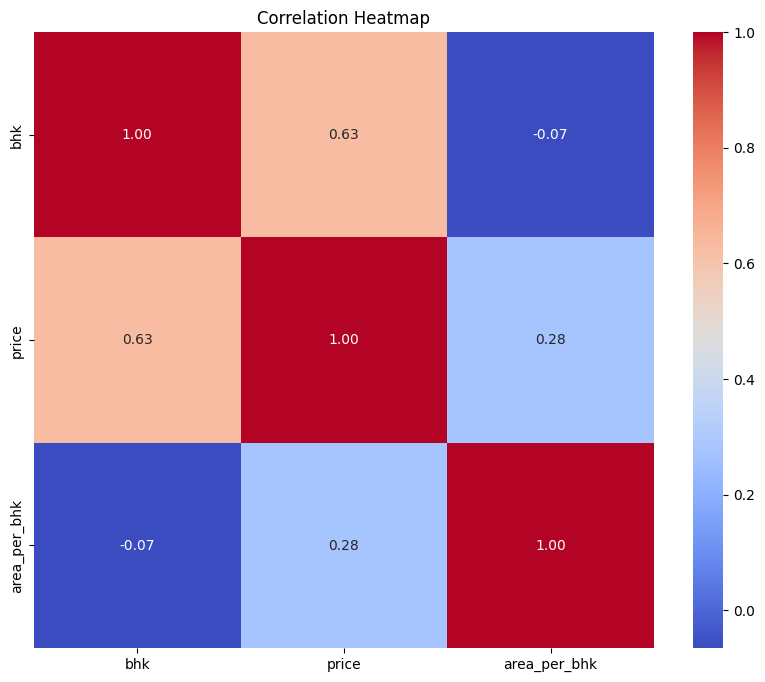

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns
numeric_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns

# Correlation matrix
corr = df_clean[numeric_cols].corr()

# Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [102]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns
cat_cols = df_clean.select_dtypes(include=['object']).columns
df_encoded = df_clean.copy()
for c in cat_cols:
    df_encoded[c] = LabelEncoder().fit_transform(df_encoded[c].astype(str))

In [93]:
df_encoded.head()

,bhk,type,locality,price,region,status,age,area_per_bhk
1,2,0,4957,0.5251,124,1,0,320.0
2,2,0,7014,1.7300,31,1,0,305.0
3,2,0,8464,0.5998,140,1,0,438.0
4,2,0,4280,0.9411,117,1,0,329.5
5,2,0,951,3.3000,141,1,0,413.0


In [ ]:
df1 = df_encoded.copy()
Y = df1['price']
df1.drop(columns=['price'], inplace=True)
X = df1

In [118]:
from sklearn.feature_selection import mutual_info_regression
# Compute MI score
mi_scores = mutual_info_regression(X, Y, random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

print("Mutual Information Scores:\n", mi_scores)

Mutual Information Scores:
 locality        1.408509
area_per_bhk    1.021323
region          0.867684
bhk             0.515344
age             0.156022
status          0.085335
type            0.028576
dtype: float64


Original shape: (75070, 7)
Transformed shape after PCA: (75070, 7)


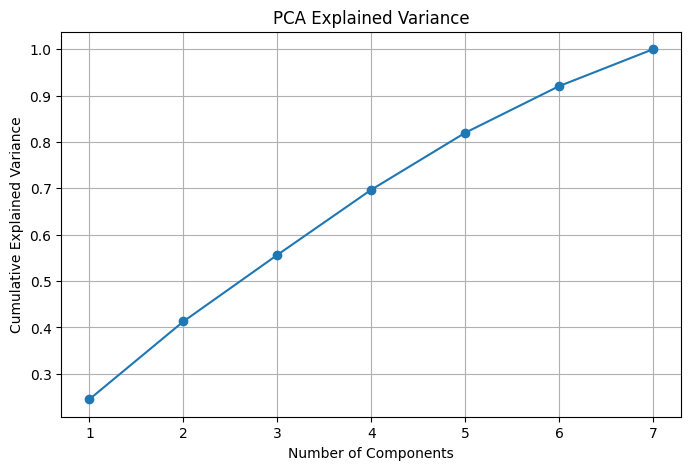

In [112]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=0.95)  # keep 95% variance
X_pca = pca.fit_transform(X_scaled)

print(f"Original shape: {X_scaled.shape}")
print(f"Transformed shape after PCA: {X_pca.shape}")

# Explained variance ratio
plt.figure(figsize=(8,5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

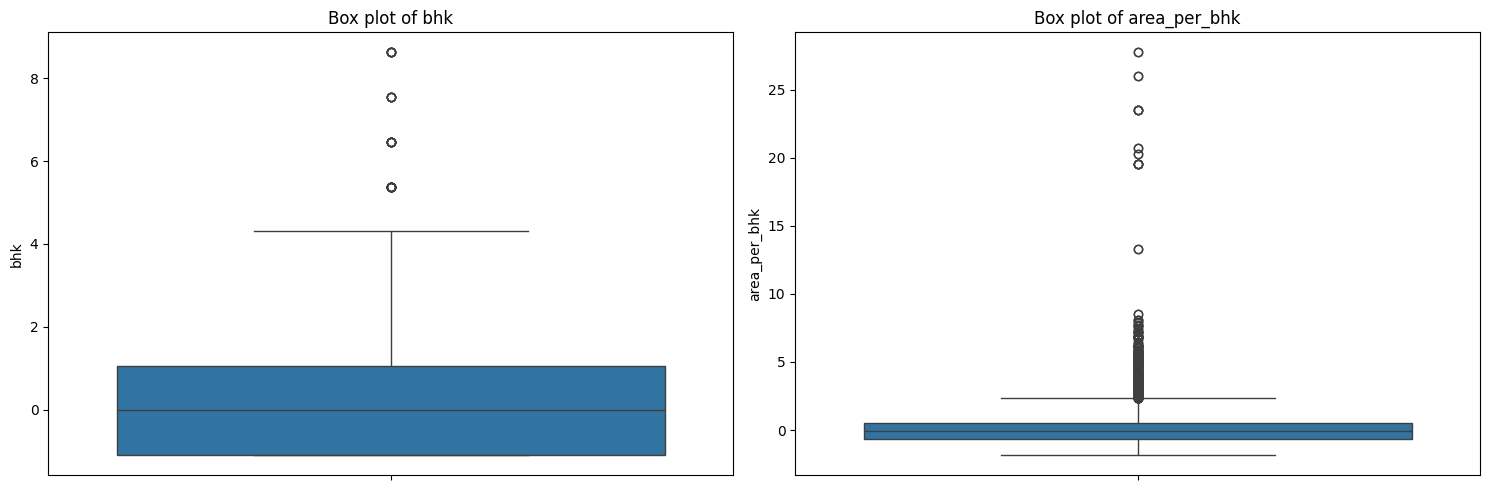

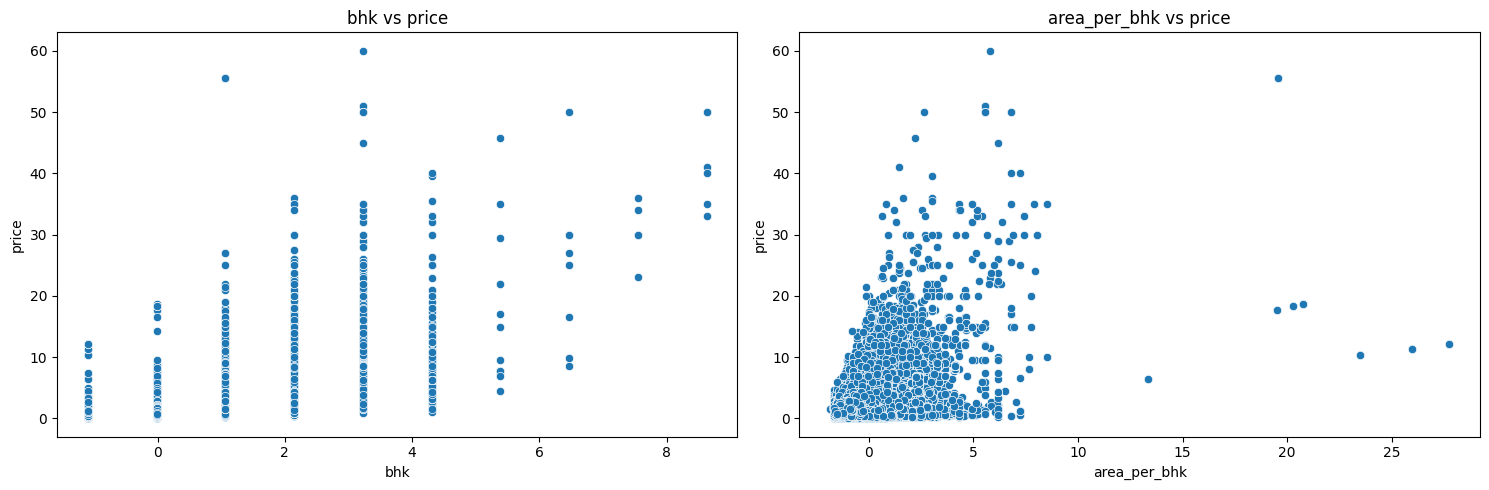

In [119]:

# Numerical features excluding target
numerical_cols = ['bhk', 'area_per_bhk']  # add more numeric columns if needed

# Box plots to check distribution and outliers
plt.figure(figsize=(15,5))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, len(numerical_cols), i)
    sns.boxplot(y=df1[col])
    plt.title(f'Box plot of {col}')
plt.tight_layout()
plt.show()

# Scatter plots vs price (target)
plt.figure(figsize=(15,5))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, len(numerical_cols), i)
    sns.scatterplot(x=df1[col], y=Y)
    plt.title(f'{col} vs price')
plt.tight_layout()
plt.show()



In [116]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [121]:
from sklearn.preprocessing import StandardScaler
numerical_cols = ['bhk','area_per_bhk']

# Standardize numerical columns
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

df1.head()

,bhk,type,locality,region,status,age,area_per_bhk
1,-0.015394,0,4957,124,1,0,-1.237708
2,-0.015394,0,7014,31,1,0,-1.331970
3,-0.015394,0,8464,140,1,0,-0.496178
4,-0.015394,0,4280,117,1,0,-1.178008
5,-0.015394,0,951,141,1,0,-0.653282


In [122]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [142]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
Y_pred = model.predict(X_test)

In [143]:
mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

In [144]:
print(mae, mse, r2)

0.22020599943967403 0.6111502962984802 0.8679185893672199


In [145]:
import os
import joblib
os.makedirs("models", exist_ok=True)
joblib.dump(model, "models/best_random_forest.pkl")

['models/best_random_forest.pkl']

In [136]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_dist_rf = {
    'n_estimators': [100, 200, 500, 800, 1000],
    'max_depth': [None, 10, 20, 30, 50],
    'max_features': ['auto', 'sqrt', 'log2', 0.3, 0.5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'bootstrap': [True, False]
}

In [137]:
rs_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=40,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [ ]:
rs_rf.fit(X_train, Y_train)


In [ ]:
print("Best params (RandomForest):", rs_rf.best_params_)
print("Best CV score (neg MAE):", rs_rf.best_score_)

best_rf = rs_rf.best_estimator_
Y_pred = best_rf.predict(X_test)

mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f"Test MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}")